In [40]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [4]:
fname = join(os.getcwd(),'data','data3SS2009.mat') # fname = caminho da pasta com arquivo

mat_contents = sio.loadmat(fname) # mat_contents carrega todos os dados do arquivo

dataset = mat_contents['dataset'] # Armazena os dados da coluna dataset

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

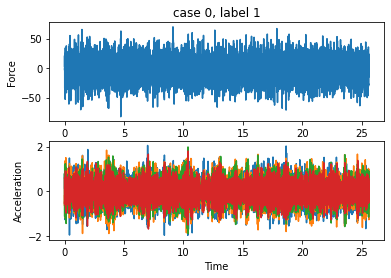

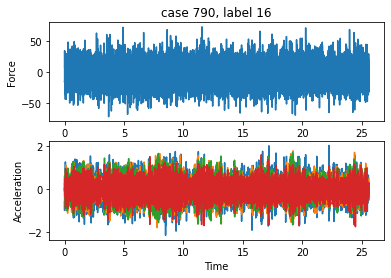

In [5]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [6]:
# Exercício 4.a.a

#loop feito para cada canal e cada sequência de medidas
#Importações indicadas no tutorial da página
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg  

Channels = [Ch2, Ch3, Ch4, Ch5]
X1 = []
n_lag = 30

for Channel in Channels:
    parameters = []
    for case in range(Nc):
        AR_Ch = AutoReg(Channel[:,case],lags=n_lag).fit()
        parameters.append(AR_Ch.params)
    parameters = np.vstack(tuple(parameters))
    print('Output shape = {}'.format(parameters.shape))
    X1.append(parameters)

X1 = np.hstack(X1)
X1.shape #Formato da matriz final

Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)


(850, 124)

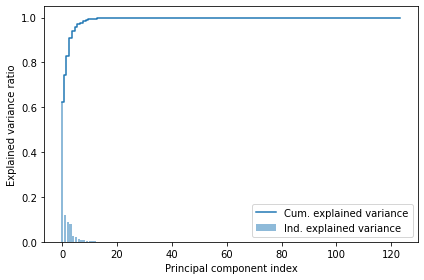

(850, 10)

In [7]:
# Exercício 4.a.b
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X1)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_variance = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',label='Ind. explained variance')
plt.step(range(0,len(cum_sum_variance)), cum_sum_variance, where='mid', label='Cum. explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

X1_reduced=pca.fit_transform(X1)
componentes=len(cum_sum_variance[cum_sum_variance<0.99])
X2=X1_reduced[:,0:componentes]
X2.shape

# X3 -> T2(T1(X3)) -> OUTPUT (1 a 17)

In [8]:
# Exercício 4.b

# Utilizando métodos descritos em:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
# E no slide 12 da aula 2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
X1s = scaler.fit_transform(X1)
X2s = scaler.fit_transform(X2)

indDam = y > 9

dfARed = pd.concat([pd.DataFrame(X1s),pd.DataFrame({'target':indDam})], axis=1)
dfPCA = pd.concat([pd.DataFrame(X2s),pd.DataFrame({'target':indDam})], axis=1)

dfPCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,-0.252236,-0.312300,-0.234238,-0.012273,-0.129277,-0.010447,-0.085838,-0.070841,-0.195128,-0.051741
std,0.582294,0.450444,0.235347,0.427869,0.369069,0.354312,0.367903,0.350867,0.289218,0.342014
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.820990,-0.605487,-0.402430,-0.285883,-0.381873,-0.189913,-0.359643,-0.277146,-0.345575,-0.254795
50%,-0.425344,-0.470663,-0.246178,0.038969,-0.206845,-0.028918,-0.119966,-0.071913,-0.167205,-0.007364
75%,0.352590,-0.222251,-0.077246,0.292005,0.141888,0.149019,0.141957,0.119499,-0.040920,0.172722
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


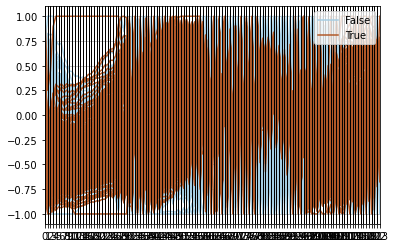

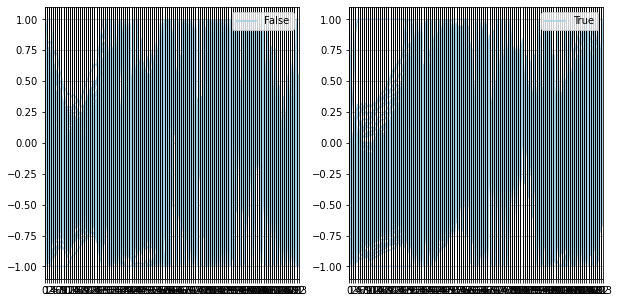

In [9]:
# Exercício 4.c
plt.figure()
pd.plotting.parallel_coordinates(dfARed, 'target', colormap=plt.get_cmap('Paired'))
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(121)
pd.plotting.parallel_coordinates(dfARed[dfARed['target']==0], 'target', colormap=plt.get_cmap('Paired'))
plt.subplot(122)
pd.plotting.parallel_coordinates(dfARed[dfARed['target']==1], 'target', colormap=plt.get_cmap('Paired'))
plt.show()

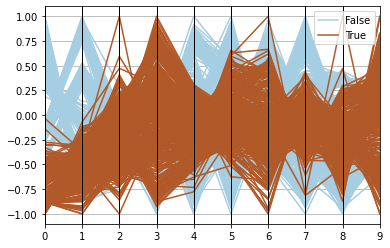

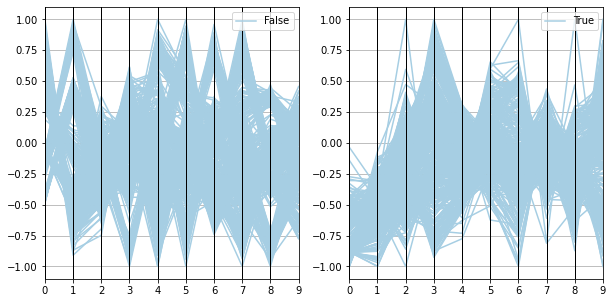

In [10]:
# Continuação exercício 4.c
plt.figure()
pd.plotting.parallel_coordinates(dfPCA, 'target', colormap=plt.get_cmap('Paired'))
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(121)
pd.plotting.parallel_coordinates(dfPCA[dfPCA['target']==0], 'target', colormap=plt.get_cmap('Paired'))
plt.subplot(122)
pd.plotting.parallel_coordinates(dfPCA[dfPCA['target']==1], 'target', colormap=plt.get_cmap('Paired'))
plt.show()

In [11]:
# Exercício 5

from sklearn.linear_model import LogisticRegression

Matrizes = [X1s, X2s]
nome_matriz = "X1s"
for matriz in Matrizes:
    softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",C=10, max_iter = 1000)
    softmax_reg.fit(matriz,y)
    num_iter = softmax_reg.n_iter_
    print(f"Foram necessárias {num_iter} iterações para ajustar {nome_matriz}.")
    Yh = np.zeros(850)
    
    for i in range(850):
        Yh[i] = softmax_reg.predict([matriz[i,:]])
    erros = 0    

    for j in range(850):
        if Yh[j] != y[j]:
            erros+=1
    perc_acertos = (850-erros)/850*100
    print(f"O modelo que ajustou {nome_matriz} acertou em {perc_acertos:.2f} % dos casos.\n")
    nome_matriz = "X2s"

Foram necessárias [356] iterações para ajustar X1s.
O modelo que ajustou X1s acertou em 100.00 % dos casos.

Foram necessárias [107] iterações para ajustar X2s.
O modelo que ajustou X2s acertou em 98.24 % dos casos.



In [59]:
# AULA 3 - Exercício 1

matrizes = [X1s, X2s]
precisao_SVM = []
precisao_KNN = []
nome_matrizes= ["X1s","X2s"]
i = 0

for matriz in matrizes:
    erros_SVM = 0
    erros_KNN = 0
    
    clf_SVM = svm.SVC(random_state=0).fit(matriz,y)
    SVM_yh = clf_SVM.predict(matriz)
    
    clf_KNN = KNeighborsClassifier().fit(matriz,y)
    KNN_yh = clf_KNN.predict(matriz)
    
    for j in range(850):
        if SVM_yh[j] != y[j]:
            erros_SVM +=1
        if KNN_yh[j] != y[j]:
            erros_KNN +=1
            
    perc_acertos_SVM = (850-erros_SVM)/850*100
    precisao_SVM.append(perc_acertos_SVM)
    
    perc_acertos_KNN = (850-erros_KNN)/850*100
    precisao_KNN.append(perc_acertos_KNN)
    
    print(f"O método SVM para a matriz {nome_matrizes[i]} teve precisão de {precisao_SVM[i]:.2f} %.")
    print(f"O método KNN para a matriz {nome_matrizes[i]} teve precisão de {precisao_KNN[i]:.2f} %.")
    i+=1



O método SVM para a matriz X1s teve precisão de 99.76 %.
O método KNN para a matriz X1s teve precisão de 99.76 %.
O método SVM para a matriz X2s teve precisão de 98.47 %.
O método KNN para a matriz X2s teve precisão de 98.35 %.


In [93]:
#AULA 3 - Exercício 2
#Variando parâmetros do SVM para X1s
C_SVM = [0.01,0.1,1,10,100]
matrizes = [X1s]
modelos_kernel = ['linear','polynomial_2','polynomial_3','sigmoid' ]
precisao_SVM = []
nome_matrizes= ["X1s"]


for Fator_C in C_SVM:
    i = 0
    for matriz in matrizes:
        k=0
        for modelo in modelos_kernel:
            erros_SVM = 0
            a=1
            if modelo == 'polynomial_2':
                modelo='poly'
                a=2
            if modelo == 'polynomial_3':
                modelo='poly'
                a=3
            clf_SVM = svm.SVC(C=Fator_C,kernel=modelo, random_state=0,degree=a).fit(matriz,y)
            SVM_yh = clf_SVM.predict(matriz)

            for j in range(850):
                if SVM_yh[j] != y[j]:
                    erros_SVM +=1

            perc_acertos_SVM = (850-erros_SVM)/850*100
            precisao_SVM.append(perc_acertos_SVM)

            print(f"O método SVM {modelos_kernel[k]} com C = {Fator_C} para a matriz {nome_matrizes[i]} teve precisão de {perc_acertos_SVM:.2f} %.")
            k+=1
        i+=1

#Para a matriz X1s...
#O modelo linear teve precisão de 100% nos casos em que C=1,10 e 100.
#O modelo polinomial teve precisão de 100% nos casos em que C=10 e 100.
#A maior precisão obtida do modelo sigmoide foi de 98,24%, quando C = 1


O método SVM linear com C = 0.01 para a matriz X1s teve precisão de 98.71 %.
O método SVM polynomial_2 com C = 0.01 para a matriz X1s teve precisão de 93.06 %.
O método SVM polynomial_3 com C = 0.01 para a matriz X1s teve precisão de 77.41 %.
O método SVM sigmoid com C = 0.01 para a matriz X1s teve precisão de 89.06 %.
O método SVM linear com C = 0.1 para a matriz X1s teve precisão de 99.76 %.
O método SVM polynomial_2 com C = 0.1 para a matriz X1s teve precisão de 97.18 %.
O método SVM polynomial_3 com C = 0.1 para a matriz X1s teve precisão de 96.00 %.
O método SVM sigmoid com C = 0.1 para a matriz X1s teve precisão de 92.12 %.
O método SVM linear com C = 1 para a matriz X1s teve precisão de 100.00 %.
O método SVM polynomial_2 com C = 1 para a matriz X1s teve precisão de 99.76 %.
O método SVM polynomial_3 com C = 1 para a matriz X1s teve precisão de 100.00 %.
O método SVM sigmoid com C = 1 para a matriz X1s teve precisão de 98.24 %.
O método SVM linear com C = 10 para a matriz X1s te

In [94]:
#AULA 3 - Exercício 2
#Variando parâmetros do SVM para X2s
C_SVM = [0.01,0.1,1,10,100]
matrizes = [X2s]
modelos_kernel = ['linear','polynomial_2','polynomial_3','sigmoid' ]
precisao_SVM = []
nome_matrizes= ["X2s"]


for Fator_C in C_SVM:
    i = 0
    for matriz in matrizes:
        k=0
        for modelo in modelos_kernel:
            erros_SVM = 0
            a=1
            if modelo == 'polynomial_2':
                modelo='poly'
                a=2
            if modelo == 'polynomial_3':
                modelo='poly'
                a=3
            clf_SVM = svm.SVC(C=Fator_C,kernel=modelo, random_state=0,degree=a).fit(matriz,y)
            SVM_yh = clf_SVM.predict(matriz)

            for j in range(850):
                if SVM_yh[j] != y[j]:
                    erros_SVM +=1

            perc_acertos_SVM = (850-erros_SVM)/850*100
            precisao_SVM.append(perc_acertos_SVM)

            print(f"O método SVM {modelos_kernel[k]} com C = {Fator_C} para a matriz {nome_matrizes[i]} teve precisão de {perc_acertos_SVM:.2f} %.")
            k+=1
        i+=1

#Para a matriz X2s...
#A maior precisão do modelo linear foi de 99,18% para C=10.
#A maior precisão do modelo polinomial de ordem 2 foi de 99,41% para C=100.
#A maior precisão do modelo polinomial de ordem 3 foi de 99,41% para C=100.
#A maior precisão obtida do modelo sigmoide foi de 96,47%, quando C = 1


O método SVM linear com C = 0.01 para a matriz X2s teve precisão de 94.00 %.
O método SVM polynomial_2 com C = 0.01 para a matriz X2s teve precisão de 91.41 %.
O método SVM polynomial_3 com C = 0.01 para a matriz X2s teve precisão de 83.88 %.
O método SVM sigmoid com C = 0.01 para a matriz X2s teve precisão de 92.12 %.
O método SVM linear com C = 0.1 para a matriz X2s teve precisão de 96.82 %.
O método SVM polynomial_2 com C = 0.1 para a matriz X2s teve precisão de 96.94 %.
O método SVM polynomial_3 com C = 0.1 para a matriz X2s teve precisão de 96.59 %.
O método SVM sigmoid com C = 0.1 para a matriz X2s teve precisão de 94.71 %.
O método SVM linear com C = 1 para a matriz X2s teve precisão de 98.59 %.
O método SVM polynomial_2 com C = 1 para a matriz X2s teve precisão de 98.35 %.
O método SVM polynomial_3 com C = 1 para a matriz X2s teve precisão de 98.24 %.
O método SVM sigmoid com C = 1 para a matriz X2s teve precisão de 96.47 %.
O método SVM linear com C = 10 para a matriz X2s teve

In [99]:
#AULA 3 - Exercício 2
#Variando parâmetros do SVM para X2s
N_KNN = [1,2,3,4,5]
matrizes = [X2s]
pesos = ['uniform','distance' ]
precisao_KNN = []
nome_matrizes= ["X2s"]


for N in N_KNN:
    for matriz in matrizes:
        for w in pesos:
            erros_KNN = 0
            clf_KNN = KNeighborsClassifier(n_neighbors=N,weights=w).fit(matriz,y)
            KNN_yh = clf_KNN.predict(matriz)
            
            for j in range(850):
                if KNN_yh[j] != y[j]:
                    erros_KNN +=1

                    
            perc_acertos_KNN = (850-erros_KNN)/850*100
            precisao_KNN.append(perc_acertos_KNN)

            print(f"O método KNN com {N} vizinho(s) e com parâmetro de peso {w} teve precisão de {perc_acertos_KNN:.2f} %.")
#Para a matriz X2s...
#Com peso uniforme em relação à distância para os pontos, o modelo teve melhor performance para 1 vizinho - 100%
#Com peso maior para vizinhos mais próximos, o modelo alcançou 100% de eficiência para todos os valores de vizinhos (1 a 5)

O método KNN com 1 vizinho(s) e com parâmetro de peso uniform teve precisão de 100.00 %.
O método KNN com 1 vizinho(s) e com parâmetro de peso distance teve precisão de 100.00 %.
O método KNN com 2 vizinho(s) e com parâmetro de peso uniform teve precisão de 98.59 %.
O método KNN com 2 vizinho(s) e com parâmetro de peso distance teve precisão de 100.00 %.
O método KNN com 3 vizinho(s) e com parâmetro de peso uniform teve precisão de 98.71 %.
O método KNN com 3 vizinho(s) e com parâmetro de peso distance teve precisão de 100.00 %.
O método KNN com 4 vizinho(s) e com parâmetro de peso uniform teve precisão de 98.35 %.
O método KNN com 4 vizinho(s) e com parâmetro de peso distance teve precisão de 100.00 %.
O método KNN com 5 vizinho(s) e com parâmetro de peso uniform teve precisão de 98.35 %.
O método KNN com 5 vizinho(s) e com parâmetro de peso distance teve precisão de 100.00 %.


[100.0,
 100.0,
 98.58823529411764,
 100.0,
 98.70588235294117,
 100.0,
 98.3529411764706,
 100.0,
 98.3529411764706,
 100.0]

In [ ]:
#AULA 3 - Exercício 3
#O modelo linear teve precisão de 100% para vários valores de C. Performou melhor que modelos polinomiais e sigmoid. 
#O modelo KNN teve precisão para 1 vizinho ou para mais, desde que haja peso maior para vizinhos mais próximos